In [16]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage.filters import frangi


# Following cell to import a bounding box (to adapt)

In [109]:
k = 1000 #we access the k-th bounding box

train_labels=pd.read_csv("/Users/mehdi/Desktop/CS230/Stenosis detection/train_labels.csv")
test_labels=pd.read_csv("/Users/mehdi/Desktop/CS230/Stenosis detection/test_labels.csv")
file = train_labels["filename"][k]
path = "/Users/mehdi/Desktop/CS230/Stenosis detection/dataset/"
img_full = np.sum(np.array(Image.open(os.path.join(path,file))),axis=2)
xmin=train_labels.iloc[k,4]
xmax=train_labels.iloc[k,6]
ymin=train_labels.iloc[k,5]
ymax=train_labels.iloc[k,7]

#img contains the bounding box we want to refine
img = img_full.T[xmin:xmax,ymin:ymax] #we have to transpose in order to match the coordinate system

# Code for refining the box once img is loaded

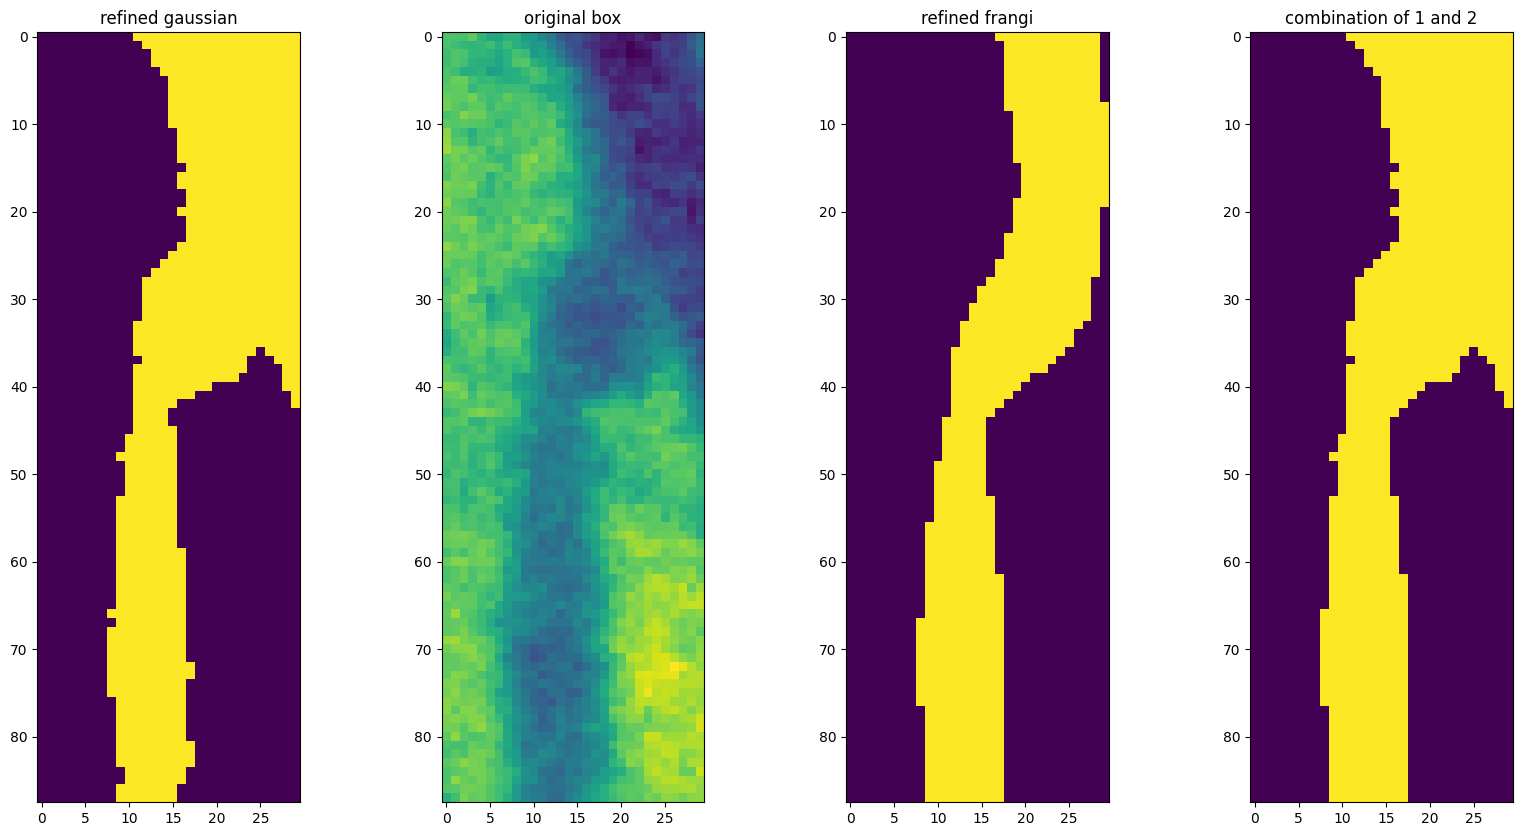

In [110]:
#parameters that can be modified to enhance the refined label
k_size = 3
sigma = 1
thsld = 0.5
frangi_thresold = 0.2
otsu=False #set True if you want touse otsu thresholding instead of thsld 

def gaussian_kernel(size, sigma=sigma):
    """Creates a Gaussian kernel with the given size and sigma"""
    x, y = np.meshgrid(np.arange(-size//2+1, size//2+1), np.arange(-size//2+1, size//2+1))
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

def gaussian_filter(img_, kernel_size=k_size, sigma=sigma):
    """Applies a Gaussian filter to the given image"""
    kernel = gaussian_kernel(kernel_size, sigma)
    smoothed = convolve(img_, kernel)
    return smoothed


def compute_otsu_criteria(im, th):
    # create the thresholded image
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1

    # compute weights
    nb_pixels = im.size
    nb_pixels1 = np.count_nonzero(thresholded_im)
    weight1 = nb_pixels1 / nb_pixels
    weight0 = 1 - weight1

    # if one of the classes is empty, eg all pixels are below or above the threshold, that threshold will not be considered
    # in the search for the best threshold
    if weight1 == 0 or weight0 == 0:
        return np.inf

    # find all pixels belonging to each class
    val_pixels1 = im[thresholded_im == 1]
    val_pixels0 = im[thresholded_im == 0]

    # compute variance of these classes
    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0
    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0

    return weight0 * var0 + weight1 * var1

def normalize(img_):
    return (img_-np.min(img_))/(np.max(img_)-np.min(img_))
    
def refine_label_gaussian(img_,otsu_):
    img_smooth = gaussian_filter(img_, kernel_size=k_size, sigma=sigma)
    if not otsu:
        return normalize(img_smooth)>thsld
    else:
        # testing all thresholds from 0 to the maximum of the image
        threshold_range = np.arange(0,1,0.01)
        criterias = [compute_otsu_criteria(img_smooth, th) for th in threshold_range]
        # best threshold is the one minimizing the Otsu criteria
        best_threshold = threshold_range[np.argmin(criterias)]
        return normalize(img_smooth)>best_threshold

def refine_label_frangi(img_,otsu_):
    refined_frangi = (normalize(frangi(normalize(img_))))
    if not otsu:
        return refined_frangi<frangi_thresold
    else:
        threshold_range = np.arange(0,1,0.01)
        criterias = [compute_otsu_criteria(refined_frangi, th) for th in threshold_range]
        # best threshold is the one minimizing the Otsu criteria
        best_threshold = threshold_range[np.argmin(criterias)]
        return normalize(refined_frangi)<best_threshold



#compute the refined label
refined1 = 1-refine_label_gaussian(img,True)
refined2 = 1-refine_label_frangi(img,False)
refined3 = (refined1+refined2)>=1

#visualize if the label is adapted what we want
fig,axs = plt.subplots(1,4,figsize=(20,10))
axs[0].imshow(refined1)
axs[0].set_title("refined gaussian")
axs[1].imshow(img)
axs[1].set_title("original box")
axs[2].set_title("refined frangi")
axs[2].imshow(refined2)
axs[3].set_title("combination of 1 and 2")
axs[3].imshow(refined3)


refined = refined3 #select here which option seems the best (if there is any that can be axccepted)